# PCamelyon Project: Prototype for MSX Project

## Phase 0: Setup, Familiarization, and Initial Exploration
**Goal**: Get everything set up, load the PCam dataset, and understand its basic characteristics.

**Tasks**:

- **Environment Setup**:
    - Create a dedicated Python environment (e.g., using Conda or venv).
    - Install core libraries: PyTorch, torchvision, HuggingFace datasets, transformers (for potential ViT later), scikit-learn, Matplotlib, Pillow/OpenCV, NumPy.

- **Dataset Loading & Inspection**:
    - Use HuggingFace datasets to load PCam.
    - Examine the dataset splits (train, validation, test).
    - Check image dimensions (96x96 pixels), color channels (RGB).
    - Analyze label distribution (is it balanced?).
    - Visualize a few sample patches from each class (tumor vs. no tumor).

**Learning Objectives Addressed**:
- Understand the initial steps of an ML/DL pipeline.
- Learn effective data loading for histology image patches.
- Simulate working with a binary classification task ("disease presence/absence").

**Transferability to MSX Project**:
- **Environment Setup**: Standard first step for any project.
- **Data Loading/Inspection**: Crucial for MSX. While PCam patches are pre-made, MSX will involve loading WSIs and then creating patches. Understanding patch characteristics here (size, content) will be informative. Visualizing samples helps build intuition for the data.
- **Binary Task**: Directly mirrors the primary goal of MSX detection (presence/absence).


### Task 1: Environment Setup

- Created a dedicated Python Environment using Conda
- Install Core Libraries

In [1]:
# Install core libraries for the project
!pip install torch torchvision torchaudio -q
!pip install datasets -q
!pip install transformers -q
!pip install scikit-learn -q
!pip install matplotlib seaborn -q
!pip install opencv-python pillow -q
!pip install "numpy<2" -q
!pip install tqdm -q

In [19]:
# Verify installation of core libraries and their versions
import torchvision
import torch
import datasets
import transformers
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import PIL
import numpy as np
print("Core libraries installed successfully:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"datasets: {datasets.__version__}")
print(f"transformers: {transformers.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"opencv-python: {cv2.__version__}")
print(f"Pillow: {PIL.__version__}")
print(f"numpy: {np.__version__}")

# supress warnings from libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use('ggplot')  # Use a nice style for plots

# Set default figure size for plots
plt.rcParams['figure.figsize'] = (10, 6)

# Extra libraries, order later
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms # Already imported
from torch.utils.data import DataLoader # Already imported

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay
)

Core libraries installed successfully:
torch: 2.2.2
torchvision: 0.17.2
datasets: 3.6.0
transformers: 4.52.3
scikit-learn: 1.6.1
matplotlib: 3.9.4
seaborn: 0.13.2
opencv-python: 4.11.0
Pillow: 11.2.1
numpy: 1.26.4


### Task 2: Dataset Loading & Inspection

Import libraries and load the dataset

In [3]:
from datasets import load_dataset

# Load PatchCamelyon dataset using library, 
# this will download dataset and cache it for future use if not available locally.

try:
    pcam = load_dataset("1aurent/PatchCamelyon")
    print("Successfully loaded PatchCamelyon dataset.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Successfully loaded PatchCamelyon dataset.


Once dataset is loaded, we can check its structure and contents.

In [4]:
print("Dataset structure:")
print(pcam)

# Calculate the total number of samples in the dataset and distribution across splits
total_samples = sum(len(pcam[split]) for split in pcam)
print(f"\nTotal samples in the dataset: {total_samples}")

# Check the available splits in the dataset
print("\nAvailable splits in the dataset:")
for split in pcam:
    split_samples = len(pcam[split])
    print(f"  - {split}: {split_samples} samples - {split_samples / total_samples * 100:.2f}%")

# Check feature names and types
print("\nFeature names and types:")
for split in pcam:
    print(f"\n{split} split features:")
    for feature_name, feature_type in pcam[split].features.items():
        print(f"  - {feature_name}: {feature_type}")

# Check the first few samples in the training set
print("\nFirst few samples in the training set:")
for i in range(3):
    print(f"Sample {i}:")
    print(pcam['train'][i])
    print()

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 262144
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
})

Total samples in the dataset: 327680

Available splits in the dataset:
  - train: 262144 samples - 80.00%
  - valid: 32768 samples - 10.00%
  - test: 32768 samples - 10.00%

Feature names and types:

train split features:
  - image: Image(mode=None, decode=True, id=None)
  - label: Value(dtype='bool', id=None)

valid split features:
  - image: Image(mode=None, decode=True, id=None)
  - label: Value(dtype='bool', id=None)

test split features:
  - image: Image(mode=None, decode=True, id=None)
  - label: Value(dtype='bool', id=None)

First few samples in the training set:
Sample 0:
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96 at 0x18D1BFA30>, 'label': False}

Sam

Check image dimensions, color channels, and label distribution.

In [5]:
# get the first sample from the training set
sample = pcam['train'][0]

image = sample['image']
label = sample['label']

print(f"\nFirst training sample image type: {type(image)}")
print(f"Image dimensions: {image.size} (width x height)")
print(f"Image mode (color channels): {image.mode}")
print(f"Label: {label}")


First training sample image type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image dimensions: (96, 96) (width x height)
Image mode (color channels): RGB
Label: False


Class labels are binary (0 = False for no tumor, 1 = True for tumor).

Let's check if the dataset is balanced in terms of class distribution.

In [6]:
def count_labels(dataset):
    '''Count the number of samples for each label in the dataset.'''
    label_counts = {0: 0, 1: 0}
    for sample in dataset:
        label_counts[sample['label']] += 1
    return label_counts

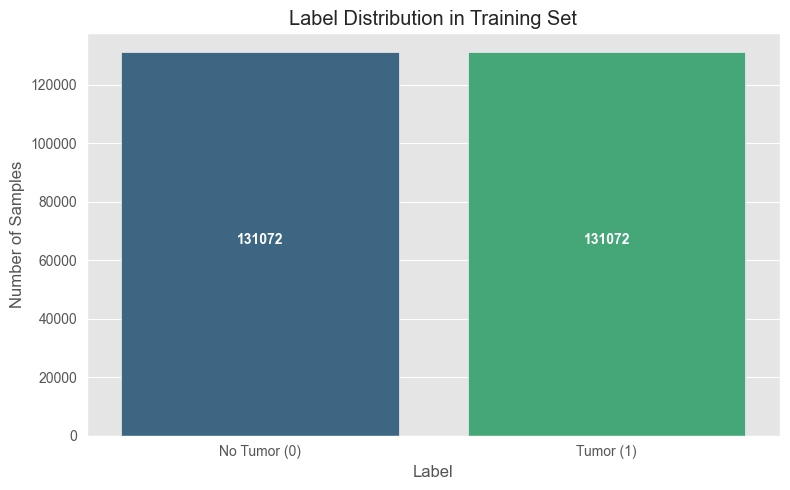

In [7]:
import collections

train_labels_raw = pcam['train']['label']  # This will be a list like [False, True, False, ...]

# Use collections.Counter to count the occurrences of False and True.
# This is highly optimized for counting items in a list.
raw_counts = collections.Counter(train_labels_raw)

# Map these boolean counts to integer keys (0 for False, 1 for True)
label_counts_for_plot = {
    0: raw_counts.get(False, 0),  # Count for 'False' (no tumor), map to key 0
    1: raw_counts.get(True, 0)    # Count for 'True' (tumor), map to key 1
}

plt.figure(figsize=(8, 5))

keys_for_plot = list(label_counts_for_plot.keys())
values_for_plot = list(label_counts_for_plot.values())

sns.barplot(x=keys_for_plot, y=values_for_plot, palette='viridis', hue=keys_for_plot, legend=False)

plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['No Tumor (0)', 'Tumor (1)'])

# Show the percentage or count on top of each bar
for i, count_val in enumerate(values_for_plot):
    plt.text(i, count_val / 2, f"{count_val}", ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Visualize a few sample patches from each class (tumor vs. no tumor).


Visualizing efficient samples from the training set:


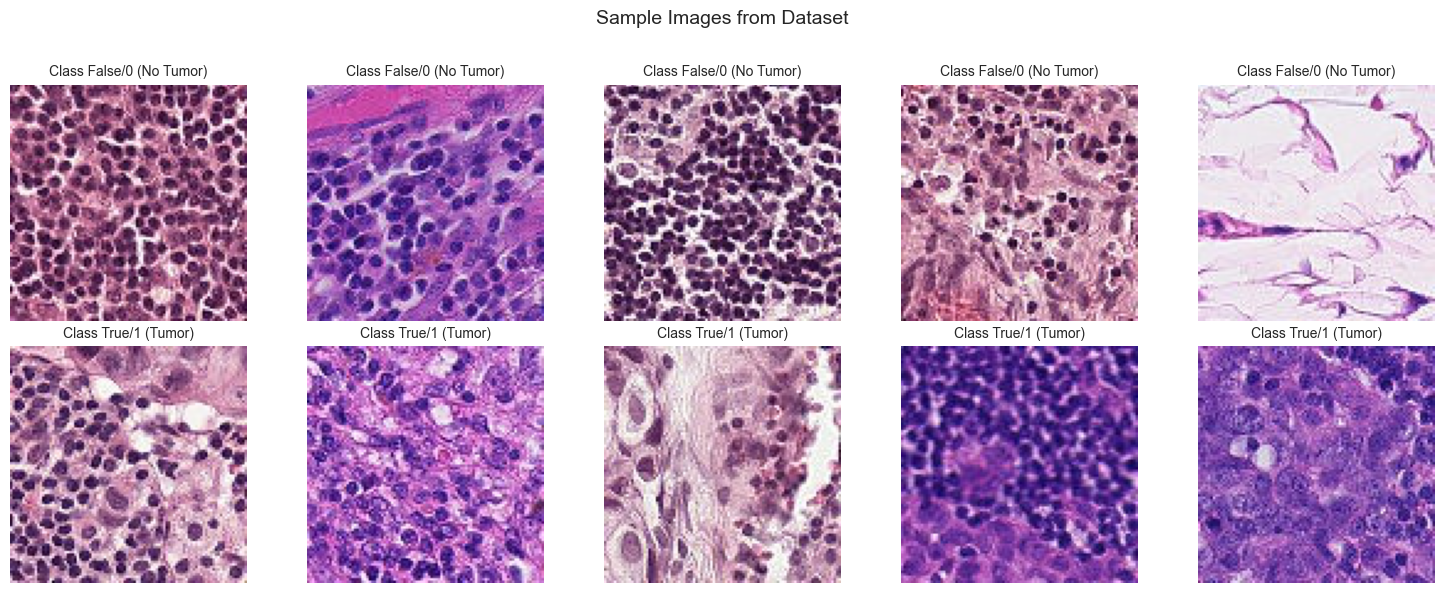

In [8]:
def show_samples(dataset, num_samples_per_class=5):
    """
    Efficiently displays a few random sample images from the dataset for each class.
    Args:
        dataset (datasets.Dataset): A HuggingFace dataset split (e.g., pcam['train']).
        num_samples_per_class (int): Number of samples to show for each class.
    """
    # Attempt to get class names from features for nice titles
    try:
        class_feature = dataset.features['label']
        class_names_map = {
            False: class_feature.names[0] if hasattr(class_feature, 'names') else "Class False/0 (No Tumor)",
            True: class_feature.names[1] if hasattr(class_feature, 'names') else "Class True/1 (Tumor)"
        }
        target_labels_for_display = [False, True] # We want to display 'no_tumor' then 'tumor'
    except (KeyError, AttributeError):
        print("Warning: Could not automatically determine class names. Using raw labels.")
        class_names_map = {False: "Label False", True: "Label True"}
        target_labels_for_display = [False, True]

    fig, axes = plt.subplots(len(target_labels_for_display), num_samples_per_class,
                             figsize=(num_samples_per_class * 3, len(target_labels_for_display) * 3))

    # Ensure axes is always 2D for consistent indexing, even if only one class or one sample
    if len(target_labels_for_display) == 1 and num_samples_per_class == 1:
        axes = np.array([[axes]])
    elif len(target_labels_for_display) == 1:
        axes = np.array([axes])
    elif num_samples_per_class == 1:
        axes = axes.reshape(-1,1)


    all_labels = dataset['label']

    for i, label_to_display in enumerate(target_labels_for_display):
        label_specific_indices = [idx for idx, actual_label in enumerate(all_labels) if actual_label == label_to_display]

        if not label_specific_indices:
            print(f"No samples found for label: {class_names_map[label_to_display]}")
            for j in range(num_samples_per_class):
                if i < axes.shape[0] and j < axes.shape[1]: # Check bounds
                    ax = axes[i, j]
                    ax.text(0.5, 0.5, 'No samples', ha='center', va='center')
                    ax.axis('off')
            continue

        # Shuffle indices to get random samples
        np.random.shuffle(label_specific_indices)

        # Select up to num_samples_per_class
        indices_to_show = label_specific_indices[:num_samples_per_class]

        for j, sample_idx in enumerate(indices_to_show):
            sample = dataset[sample_idx] # Fetch the actual sample using the pre-identified index
            img = sample['image'] # PIL image

            if i < axes.shape[0] and j < axes.shape[1]: # Check bounds
                ax = axes[i, j]
                ax.imshow(img)
                ax.set_title(f"{class_names_map[label_to_display]}", fontsize=10)
                ax.axis('off')
            else: # Should not happen with correct subplot setup but good for safety
                print(f"Warning: Axes index out of bounds for plot [{i},{j}]")

    plt.suptitle("Sample Images from Dataset", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

print("\nVisualizing samples from the training set:")
show_samples(pcam['train'], num_samples_per_class=5)


## Phase 1: Baseline Model Development
**Goal**: Develop a simple baseline model to classify tumor patches. We will create a custom PyTorch `Dataset` class to handle the PCam dataset, giving us more control over data loading and transformations.


In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PatchCamelyonDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        """
        Args:
            hf_dataset (datasets.Dataset): A HuggingFace dataset split (e.g., pcam['train']).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'] # This is a PIL Image

        # Convert boolean label to integer (False -> 0, True -> 1)
        label = int(item['label'])

        if self.transform:
            image = self.transform(image)

        # Ensure label is a tensor, often required by loss functions, may need to change it.
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

## Task 1: **Define basic transformations**:
1. Convert PIL Image to PyTorch Tensor
2. Normalize the image
   - For pre-trained models, it's common to use ImageNet statistics.
     Mean: [0.485, 0.456, 0.406]
     Std: [0.229, 0.224, 0.225]
3. Basic Data Augmentation (for the training set)
   - Random Horizontal Flip
   - Random Vertical Flip
   - Random Rotation (e.g., 90 degrees)

In [10]:
# Transformations for the training set (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90), # Rotates by a random angle up to 90 deg. Or use transforms.RandomChoice for 0,90,180,270
    # Consider adding transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05) later
    transforms.ToTensor(), # Converts PIL image (H, W, C) in range [0, 255] to (C, H, W) in range [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for validation and test sets (no augmentation, just tensor conversion and normalization)
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of our custom Dataset for each split
train_custom_dataset = PatchCamelyonDataset(pcam['train'], transform=train_transform)
val_custom_dataset = PatchCamelyonDataset(pcam['valid'], transform=val_test_transform)
test_custom_dataset = PatchCamelyonDataset(pcam['test'], transform=val_test_transform) # Keep test set pristine

In [11]:
# Verify one sample from our custom dataset
img_tensor, label_tensor = train_custom_dataset[0]
print(f"\nSample from custom training dataset:")
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Image tensor dtype: {img_tensor.dtype}")
print(f"Label tensor: {label_tensor}")
print(f"Label tensor shape: {label_tensor.shape}")
print(f"Label tensor dtype: {label_tensor.dtype}")


Sample from custom training dataset:
Image tensor shape: torch.Size([3, 96, 96])
Image tensor dtype: torch.float32
Label tensor: 0.0
Label tensor shape: torch.Size([])
Label tensor dtype: torch.float32


In [12]:
# Create DataLoaders
# DataLoaders handle batching, shuffling, and optionally parallel data loading.
BATCH_SIZE = 64 # Adjust this based on GPU memory

# num_workers = 2 was causing problems, changing it to 0 solved it {{WHY?}}
train_dataloader = DataLoader(train_custom_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Fetch a batch to see its structure
train_batch_images, train_batch_labels = next(iter(train_dataloader))
print(f"\nSample batch from training DataLoader:")
print(f"Images batch shape: {train_batch_images.shape}")
print(f"Labels batch shape: {train_batch_labels.shape}")


Sample batch from training DataLoader:
Images batch shape: torch.Size([64, 3, 96, 96])
Labels batch shape: torch.Size([64])


In [13]:
# For BCEWithLogitsLoss, the label often needs to be reshaped to [BATCH_SIZE, 1] if model output is [BATCH_SIZE, 1]
# If label_tensor was torch.tensor(label, dtype=torch.float32).unsqueeze(0) in __getitem__
# then train_batch_labels.shape would be [BATCH_SIZE, 1]
# Let's make that change for clarity with BCEWithLogitsLoss.

print("\nAdjusting label shape in Dataset for BCEWithLogitsLoss...")
class PatchCamelyonDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']
        label = int(item['label']) # Convert boolean to int
        if self.transform:
            image = self.transform(image)
        # For BCEWithLogitsLoss, if model output is [batch_size, 1], target should be [batch_size, 1]
        label = torch.tensor([label], dtype=torch.float32) # Make it [1] shape
        return image, label


Adjusting label shape in Dataset for BCEWithLogitsLoss...


In [14]:
# Re-create datasets and dataloaders with the updated Dataset class
train_custom_dataset = PatchCamelyonDataset(pcam['train'], transform=train_transform)
val_custom_dataset = PatchCamelyonDataset(pcam['valid'], transform=val_test_transform)
test_custom_dataset = PatchCamelyonDataset(pcam['test'], transform=val_test_transform)

train_dataloader = DataLoader(train_custom_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

img_tensor, label_tensor = train_custom_dataset[0]
print(f"\nSample from *updated* custom training dataset:")
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Label tensor: {label_tensor}")
print(f"Label tensor shape: {label_tensor.shape}") # Expected: torch.Size([1])

train_batch_images, train_batch_labels = next(iter(train_dataloader))
print(f"\nSample batch from *updated* training DataLoader:")
print(f"Images batch shape: {train_batch_images.shape}")
print(f"Labels batch shape: {train_batch_labels.shape}") # Expected: torch.Size([BATCH_SIZE, 1])


Sample from *updated* custom training dataset:
Image tensor shape: torch.Size([3, 96, 96])
Label tensor: tensor([0.])
Label tensor shape: torch.Size([1])

Sample batch from *updated* training DataLoader:
Images batch shape: torch.Size([64, 3, 96, 96])
Labels batch shape: torch.Size([64, 1])


## Task 2: Model Selection & Adaptation

Will choose a pre-trained Convolutional Neural Network (CNN) and adapt its final layer for our binary classification task (tumor vs. no tumor).

Will coninue with ResNet18 as it is lightweight and effective for image classification tasks.

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

# Ensure device is set correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load a pre-trained ResNet18 model ---
# weights=models.ResNet18_Weights.IMAGENET1K_V1 ensures we get the recommended pre-trained weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print("Original ResNet18 model structure:")
print(model)

# --- Modify the final fully connected layer (classifier) ---
# ResNet18's final layer is typically named 'fc'
num_ftrs = model.fc.in_features  # Get the number of input features to the original 'fc' layer

# Replace the 'fc' layer with a new nn.Linear layer.
# For binary classification with BCEWithLogitsLoss, we need 1 output neuron.
model.fc = nn.Linear(num_ftrs, 1)

# Move the model to the selected device
model = model.to(device)

print("\nModified ResNet18 model structure (notice the 'fc' layer):")
print(model)

# --- Test with a dummy batch of data (similar to what DataLoader would provide) ---
# Example: Create a dummy input if dataloaders aren't handy right now
# For ResNet18, input size is typically (N, 3, H, W), H,W >= 224 usually, but it adapts.
# PCam patches are 96x96. Pre-trained models often work fine with smaller inputs,
# or one might add an adaptive pooling layer, but torchvision models often handle this.
# Our ToTensor() and Normalize() are already preparing the data.
if 'train_batch_images' in locals() or 'train_batch_images' in globals():
    dummy_input = train_batch_images.to(device) # Use actual batch if available
    print(f"\nUsing a real batch for dummy input with shape: {dummy_input.shape}")
else:
    # If train_batch_images is not defined, create a synthetic one
    print(f"\nCreating a synthetic dummy input...")
    dummy_input = torch.randn(BATCH_SIZE, 3, 96, 96).to(device) # N, C, H, W

# Perform a forward pass
with torch.no_grad(): # No need to track gradients for this test
    model.eval() # Set model to evaluation mode for consistent behavior (e.g., for BatchNorm)
    output_logits = model(dummy_input)
    model.train() # Set back to training mode for actual training later

print(f"\nOutput logits shape: {output_logits.shape}") # Expected: torch.Size([BATCH_SIZE, 1])
print(f"Example output logits (first 5): \n{output_logits[:5]}")

# The output_logits are the raw scores before a sigmoid.
# For BCEWithLogitsLoss, these are exactly what we need.
# The labels from our DataLoader are shaped [BATCH_SIZE, 1] and are 0.0 or 1.0. This matches!

Using device: cpu
Original ResNet18 model structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

## Task 3: Training Pipeline

### 1. Loss Function

For a binary classification task where the model outputs a single raw logit, the torch.nn.BCEWithLogitsLoss is the most appropriate and numerically stable choice.
- It combines a Sigmoid layer and the Binary Cross Entropy loss in one single class.
- It expects raw logits as input (which our model provides) and target labels as probabilities (0.0 or 1.0 for binary, which our DataLoader provides).

In [16]:
# Loss Function
# Using BCEWithLogitsLoss as our model outputs raw logits (one per sample)
# and our labels are 0.0 or 1.0.
criterion = nn.BCEWithLogitsLoss()

### 2. Optimizer
The optimizer is responsible for updating the model's weights based on the gradients computed during backpropagation. Adam or AdamW are popular and generally good choices as they adapt the learning rate per parameter. SGD with momentum can also work well but often requires more careful tuning of the learning rate and momentum. Let's start with Adam.
- We need to tell the optimizer which parameters to update (i.e., all parameters of our model).
- We also set a learning rate (lr). This is a critical hyperparameter. A common starting point is 1e-3 or 1e-4.

In [17]:
import torch.optim as optim

LEARNING_RATE = 1e-4 # A common starting point, can be tuned later
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3. Training and Validation Loops

This is the core of the training process.
- Training Loop (train_one_epoch function):
    - Iterates over the train_dataloader for one epoch.
    - Sets the model to training mode (model.train()).
    - For each batch:
        - Moves data and labels to the device.
        - Clears previous gradients (optimizer.zero_grad()).
        - Performs a forward pass to get predictions (outputs = model(inputs)).
        - Calculates the loss (loss = criterion(outputs, labels)).
        - Performs backpropagation to compute gradients (loss.backward()).
        - Updates model weights (optimizer.step()).
        - Tracks running loss and accuracy.

- Validation Loop (validate_one_epoch function):
    - Iterates over the val_dataloader.
    - Sets the model to evaluation mode (model.eval()).
    - Disables gradient calculations (with torch.no_grad():) as we are only evaluating, not training.
    - Calculates loss and accuracy on the validation set. This helps monitor for overfitting.

We'll also track basic metrics: loss and accuracy. Accuracy for binary classification with logits can be calculated by applying a sigmoid to the output, thresholding at 0.5, and comparing with the true labels.

In [18]:
from tqdm import tqdm # For progress bars

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Wrap dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # Shape: [batch_size, 1] (logits)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)

        # For accuracy: convert logits to probabilities, then to predictions
        probs = torch.sigmoid(outputs) # Shape: [batch_size, 1]
        preds = (probs > 0.5).float()  # Shape: [batch_size, 1], converts to 0.0 or 1.0

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), acc=correct_predictions/total_samples)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():  # No need to track gradients during validation
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), acc=correct_predictions/total_samples)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

### 4. Main Training Orchestration

Now, let's put it all together and run the training for a few epochs.

In [34]:
# # --- Main Training ---
# NUM_EPOCHS = 5 # Start with a small number of epochs for this baseline
#
# print(f"\nStarting training for {NUM_EPOCHS} epochs...")
#
# for epoch in range(NUM_EPOCHS):
#     print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
#
#     train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
#     print(f"Epoch {epoch+1} Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")
#
#     val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion, device)
#     print(f"Epoch {epoch+1} Validation: Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")
#
#     if (epoch + 1) % 5 == 0: # Save every 5 epochs, or based on best validation accuracy
#         torch.save(model.state_dict(), f"pcam_resnet18_epoch_{epoch+1}.pth")
#
# print("\nFinished Training.")


Starting training for 5 epochs...

--- Epoch 1/5 ---


Epoch 1 Training: Loss = 0.2155, Accuracy = 0.9144


Epoch 1 Validation: Loss = 0.2894, Accuracy = 0.8860

--- Epoch 2/5 ---


Epoch 2 Training: Loss = 0.1537, Accuracy = 0.9419


Epoch 2 Validation: Loss = 0.3731, Accuracy = 0.8669

--- Epoch 3/5 ---


Epoch 3 Training: Loss = 0.1325, Accuracy = 0.9511


Epoch 3 Validation: Loss = 0.2856, Accuracy = 0.8919

--- Epoch 4/5 ---


Epoch 4 Training: Loss = 0.1181, Accuracy = 0.9569


Epoch 4 Validation: Loss = 0.3278, Accuracy = 0.8869

--- Epoch 5/5 ---


Epoch 5 Training: Loss = 0.1087, Accuracy = 0.9604


Epoch 5 Validation: Loss = 0.3384, Accuracy = 0.8875

Finished Training.


**Interpretation**:
- Training Progress:
    - **Training Loss** decreased consistently from `0.2155` to `0.1087`. This shows that the model is learning from the training data.
    - **Training Accuracy** increased steadily from `0.9144` (91.44%) to `0.9604` (96.04%). This also indicates effective learning on the training set.
- Validation Performance:
    - **Validation Loss** started at `0.2894`, increased in epoch to `0.3731`, and then fluctuated around `0.28 - 0.33`. It didn't consistently decrease like the training loss. By Epoch 5, it's `0.3384`, which is higher than the training loss.
    - **Validation Accuracy** started at `0.8860` (88.60%), dipped slightly, then hovered around `0.88 - 0.89` (88 - 89%), ending at `0.8875` in Epoch 5. It is noticeably lower than the final training accuracy.
- Key Observation:
    - Clear gap between training performance and validation performance.
    - This is a sign of **OVERFITTING**. The model learned the data very well, perhaps even memorizing some of its specific noise and patterns, but it's not generalizing as effectively to the unseen validation data. The validation loss even started to trend upwards or stagnate while training loss continued to decrease, which is a strong indicator.

In [20]:
# --- Use saved trained model ---
# Define the model architecture (should be same as during training)
eval_model = models.resnet18(weights=None) # Start with an uninitialized model
num_ftrs = eval_model.fc.in_features
eval_model.fc = nn.Linear(num_ftrs, 1) # Adapt for binary classification

# Define the path to your saved model
MODEL_PATH = "pcam_resnet18_epoch_5.pth"

# Load the state dictionary
try:
    eval_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Successfully loaded model weights from {MODEL_PATH}")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}. Please check the path.")
    print("Ensure you have trained and saved a model checkpoint.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

eval_model = eval_model.to(device)

Successfully loaded model weights from pcam_resnet18_epoch_5.pth


## Task 4: Detailed Evaluation on Test Set
**Goal:** Assess the generalization performance of the trained ResNet18 model on unseen data. This is important to understand how well the model might perform on a real-world scenario.


In [21]:
# --- Prepare for Evaluation & Collect Predictions and True Labels ---
eval_model.eval()  # Set the model to evaluation mode

all_labels = []
all_predictions = []
all_probabilities = [] # For ROC AUC

with torch.no_grad(): # Disable gradient calculations (no backpropagation, no need)
    progress_bar = tqdm(test_dataloader, desc="Evaluating on Test Set", leave=False)
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device) # Shape: [batch_size, 1]

        outputs = eval_model(inputs) # Logits, Shape: [batch_size, 1]

        # Probabilities for ROC AUC
        probs = torch.sigmoid(outputs) # Shape: [batch_size, 1]
        all_probabilities.extend(probs.cpu().numpy()) # Store probabilities

        # Predictions (0 or 1)
        preds = (probs > 0.5).float() # Shape: [batch_size, 1]
        all_predictions.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

# Convert lists of arrays/tensors to single NumPy arrays
# Ensure they are 1D for scikit-learn metrics
all_labels = np.array(all_labels).flatten()
all_predictions = np.array(all_predictions).flatten()
all_probabilities = np.array(all_probabilities).flatten() # Probabilities for the positive class

print("\nEvaluation complete. Collected predictions and labels.")
print(f"Shape of all_labels: {all_labels.shape}")
print(f"Shape of all_predictions: {all_predictions.shape}")
print(f"Shape of all_probabilities: {all_probabilities.shape}")


Evaluation complete. Collected predictions and labels.
Shape of all_labels: (32768,)
Shape of all_predictions: (32768,)
Shape of all_probabilities: (32768,)


In [22]:
# --- Calculate Performance Metrics ---
accuracy = accuracy_score(all_labels, all_predictions)
# For precision, recall, f1_score:
#   - 'binary' assumes positive label is 1 (which is our case: 1 for tumor)
#   - zero_division=0 handles cases where a class might not be predicted, avoiding warnings.
precision = precision_score(all_labels, all_predictions, pos_label=1, zero_division=0)
recall = recall_score(all_labels, all_predictions, pos_label=1, zero_division=0)
f1 = f1_score(all_labels, all_predictions, pos_label=1, zero_division=0)
roc_auc = roc_auc_score(all_labels, all_probabilities) # Use probabilities for ROC AUC

print("\n--- Test Set Performance Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (for class 1 - Tumor)")
print(f"Recall:    {recall:.4f} (for class 1 - Tumor)")
print(f"F1-score:  {f1:.4f} (for class 1 - Tumor)")
print(f"AUC-ROC:   {roc_auc:.4f}")


--- Test Set Performance Metrics ---
Accuracy:  0.8411
Precision: 0.9623 (for class 1 - Tumor)
Recall:    0.7100 (for class 1 - Tumor)
F1-score:  0.8171 (for class 1 - Tumor)
AUC-ROC:   0.9493


**Interpretation:**
- Accuracy: `0.8411` (84.11%)
    - Overall, 84.11% of the test patches were classified correctly (either as tumor or no-tumor).
    - This is a decent starting point, but it is lower than both the final training accuracy (96.0%) and the final validation accuracy (88.8%). This reinforces the overfitting observation (performance drops when moving from seen data to truly unseen test data).
- Precision (for class 1 – Tumor): `0.9623` (96.23%)
    - When the model predicts a patch _is_ a tumor, it is correct 96.23% of the time.
    - This is a very high value! It means that the model produces very few False Positives (FP). If it says "tumor" you cna be quite confident it is indeed a tumor.
- Recall (for class 1 – Tumor): `0.7100` (71.00%)
    - Out of all the patches that _actually are_ tumors, the model correctly identified 71.00% of them.
    - THis is significantly lower than the precision. It means the model misses a considerable number of actual tumors, leading to many False Negatives (FN). This is a main weakness.
- F1-score (for class 1 – Tumor): `0.8171` (81.71%)
    - The harmonic mean of precision and recall. It provides a single score that balances both.
    - It's pulled down from the high precision due to the lower recall. An F1-score of ~0.82 suggests reasonable performance, but stresses that the imbalance between precision and recall (specifically, the low recall) is an issue.
- AUC-ROC: `0.9493` (~0.95)
    - The Area Under the Receiver Operating Characteristic Curve. It measures the model's ability to distinguish between the positive (tumor) and negative (no-tumor) classes across _all possible classification thresholds_. an AUC of 1.0 is perfect, and 0.5 is random guessing.
    - The ~0.95 score is a very good AUC score. It suggests that the model has learned features that are inherently quite discriminative between the two classes. Even if the current default threshold of 0.5 (used for precision/recall/accuracy) isn't optimal for recall, the underlying ability to separate classes is strong. This is a positive sign for potential improvement.

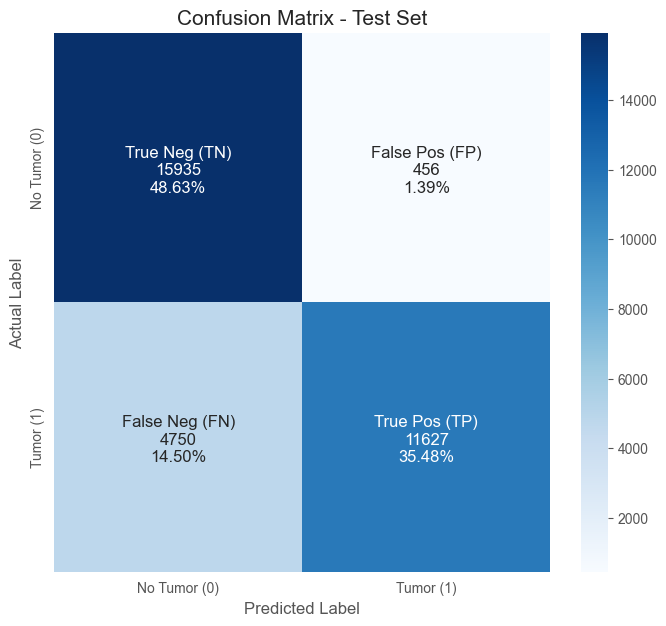

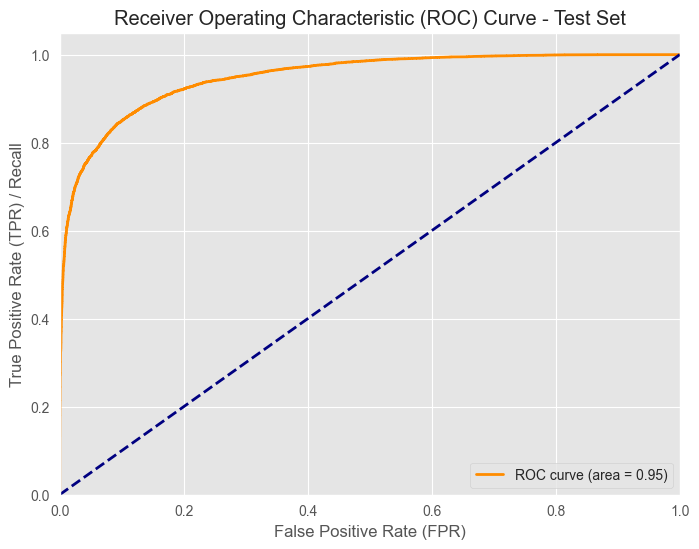

In [26]:
# --- Visualize Performance (Enhanced Confusion Matrix) ---

# Calculate Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
tn, fp, fn, tp = cm.ravel() # Extracts values in order: TN, FP, FN, TP

# Calculate percentages
total_samples_in_cm = np.sum(cm)
cm_percent = cm / total_samples_in_cm # Cell percentages

# Create labels for each cell: "Label\nValue\n(Percentage%)"
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Combine labels for heatmap annotation
annot_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
annot_labels = np.asarray(annot_labels).reshape(2,2) # Reshape to 2x2 for the heatmap

# Class labels for axes
class_labels = ['No Tumor (0)', 'Tumor (1)']

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 12, "va": "center_baseline", "ha": "center"}) # Adjust font size and alignment

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set', fontsize=15)
plt.show()

# The ROC Curve plotting remains the same:
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Task 5: Results Logging and Visualization (of Training Process)

Let's start by adjusting the main training loop to collect the training loss, training accuracy, validation loss, validation accuracy values for each of the epoch into lists. Storing these metrics will be useful for visualization.

In [27]:
# # # --- Ensure these are re-initialized for a fresh run ---
# # model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# # num_ftrs = model.fc.in_features
# # model.fc = nn.Linear(num_ftrs, 1)
# # model = model.to(device)
# # criterion = nn.BCEWithLogitsLoss()
# # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#
# NUM_EPOCHS = 15 # Or more, if you want to re-run for a longer period
# LEARNING_RATE = 1e-4
#
# history = {
#     'train_loss': [],
#     'train_acc': [],
#     'val_loss': [],
#     'val_acc': []
# }
#
# best_val_accuracy = 0.0  # Initialize best validation accuracy
# best_epoch = 0           # To store the epoch number of the best model
# PATH_BEST_MODEL = "pcam_resnet18_best_model.pth" # Path to save the best model
#
# print(f"\nStarting training for {NUM_EPOCHS} epochs (with metric logging and best model saving)...")
# print(f"Best model will be saved to: {PATH_BEST_MODEL}")
#
# for epoch in range(NUM_EPOCHS):
#     current_epoch_num = epoch + 1
#     print(f"\n--- Epoch {current_epoch_num}/{NUM_EPOCHS} ---")
#
#     # Train one epoch
#     train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
#     print(f"Epoch {current_epoch_num} Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")
#
#     # Validate one epoch
#     val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion, device)
#     print(f"Epoch {current_epoch_num} Validation: Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")
#
#     # Store metrics
#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
#
#     # Check if this is the best model so far based on validation accuracy
#     if val_acc > best_val_accuracy:
#         best_val_accuracy = val_acc
#         best_epoch = current_epoch_num
#         # Save the model's state dictionary
#         torch.save(model.state_dict(), PATH_BEST_MODEL)
#         print(f"🎉 New best model saved! Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch}")
#
#     # Optional: Periodic saving if you want multiple checkpoints
#     if current_epoch_num % 5 == 0:
#         periodic_save_path = f"pcam_resnet18_epoch_{current_epoch_num}_checkpoint.pth"
#         torch.save(model.state_dict(), periodic_save_path)
#         print(f"Saved periodic checkpoint to {periodic_save_path}")
#
# print("\nFinished Training.")
# print(f"Best validation accuracy achieved: {best_val_accuracy:.4f} at Epoch {best_epoch}")
# print(f"Best model parameters saved to: {PATH_BEST_MODEL}")
#
# # --- At this point, 'history' dictionary contains all the metrics ---
# print("\nCollected metrics history:")
# print(history)

# Later, loading the best model later for evaluation:
# best_model_state_dict = torch.load(PATH_BEST_MODEL)
# eval_model.load_state_dict(best_model_state_dict)
# eval_model.to(device)
# eval_model.eval()

In [28]:
# Manual values from previous run, avoiding other 6.5 hrs of training
history = {
    'train_loss': [0.2155, 0.1537, 0.1325, 0.1181, 0.1087],
    'train_acc':  [0.9144, 0.9419, 0.9511, 0.9569, 0.9604],
    'val_loss':   [0.2894, 0.3731, 0.2856, 0.3278, 0.3384],
    'val_acc':    [0.8860, 0.8669, 0.8919, 0.8869, 0.8875]
}

In [30]:
def plot_learning_curves(history, title_suffix=""):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title(title_suffix + 'Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.suptitle('Learning Curves', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()


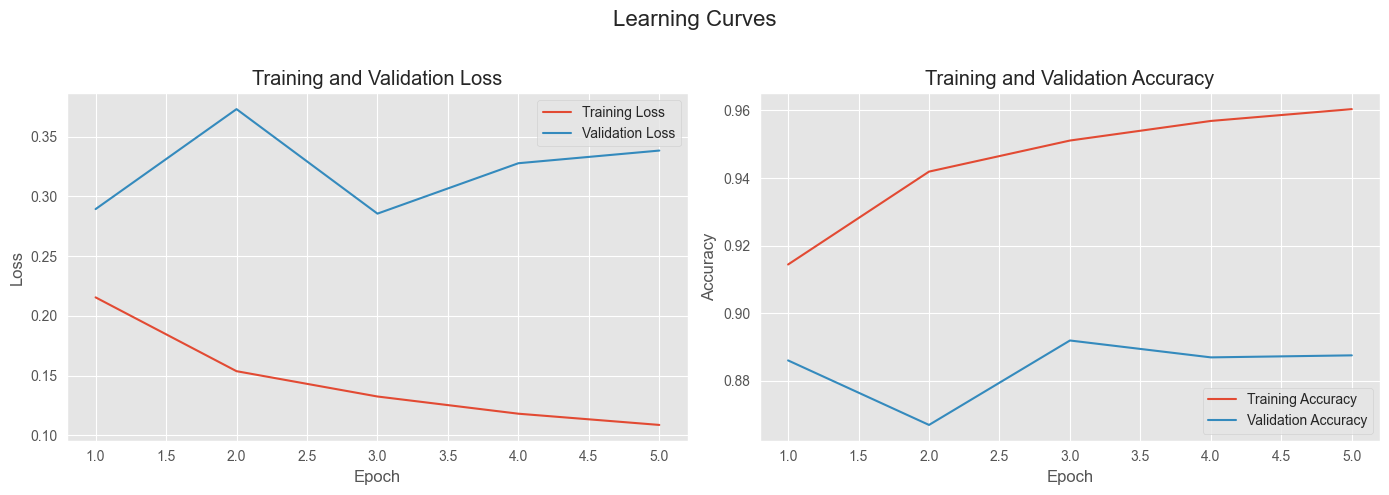

In [31]:
plot_learning_curves(history)

**Key Takeaways from these Curves**:
- **Clear Overfitting**: The most obvious takeaway is the difference between the training and validation curves.
    - Training loss goes down, validation loss goes up (or fluctuates much higher).
    - Training accuracy goes up, validation accuracy plateaus well below it (or even starts to decrease).
    - This means the model is becoming too specialized to the training data and losing its ability to generalize to new, unseen data.

- **Optimal Point for Early Stopping** (Based on these 5 Epochs):
    - If we were using validation loss as the factor for early stopping, Epoch 3 looks like the best point. It has the lowest validation loss (0.2856). After this point, the validation loss starts to increase.
    - If we were using validation accuracy, Epoch 3 also gives the highest validation accuracy (0.8919).
    - So, based only on these 5 epochs, a model saved at the end of Epoch 3 might have performed slightly better on the test set than the model saved at Epoch 5.

- **The Spike in Validation Loss at Epoch 2**: This is interesting. It suggests that at that point, the model learned something from the training data that was actively detrimental to its performance on the validation set. It then "corrected" somewhat in Epoch 3 before overfitting signs became more dominant again.

# Phase 2: Experimentation and Model Improvement

## Task 1: Hyperparameter Tuning (Simple Introduction)
**Goal**: Understand the impact of key hyperparameters on model training and performance.

Will start with the Learning Rate. We have been using `LEARNING_RATE = 1e-4` as our starting point. Let's experiment to see it's effect.

In [ ]:
def run_lr_experiment(learning_rate, num_epochs, model_architecture,
                      train_loader, val_loader, criterion_class, optimizer_class, device,
                      experiment_name=""):
    """
    Runs a training experiment for a given learning rate.

    Args:
        learning_rate (float): The learning rate to use.
        num_epochs (int): Number of epochs to train.
        model_architecture (callable): A function that returns an uninitialized model (e.g., models.resnet18).
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion_class (callable): The loss function class (e.g., nn.BCEWithLogitsLoss).
        optimizer_class (callable): The optimizer class (e.g., optim.Adam).
        device (torch.device): The device to train on.
        experiment_name (str): A name for this experiment (e.g., "lr_1e-3") for saving files.

    Returns:
        tuple: (history, best_validation_accuracy, best_epoch_number)
    """
    print(f"\n--- Running Experiment: {experiment_name} (LR: {learning_rate}) ---")

    # Re-initialize Model
    model = model_architecture(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Assuming ResNet18 structure
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    model = model.to(device)

    # Re-initialize Optimizer
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    # Re-initialize Criterion
    criterion = criterion_class()

    # Training Loop
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0.0
    best_epoch = 0
    path_best_model = f"pcam_resnet18_best_model_{experiment_name}.pth"

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        current_epoch_num = epoch + 1

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device) # globally defined or imported
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device) # globally defined or imported

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {current_epoch_num}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = current_epoch_num
            torch.save(model.state_dict(), path_best_model)
            print(f"  🎉 New best model saved! Val Acc: {best_val_acc:.4f}")

    print(f"\nFinished Training for LR={learning_rate}.")
    print(f"Best val acc for LR {learning_rate}: {best_val_acc:.4f} at Epoch {best_epoch}")
    print(f"Best model saved to: {path_best_model}")

    plot_learning_curves(history, title_suffix=f" (LR={learning_rate}) ")

    return history, best_val_acc, best_epoch


In [ ]:
NUM_EPOCHS_FOR_LR_TUNING = 10 # relatively short for now, quick comparison
lrs_to_test = [1e-3, 1e-5] # Compare with original 1e-4

# Store results from all LR experiments
lr_experiment_results = {}

for lr in lrs_to_test:
    exp_name = f"lr_{lr:.0e}".replace('-', '_minus_') # Creates a file-friendly name like "lr_1e_minus_03"
    hist, b_val_acc, b_epoch = run_lr_experiment(
        learning_rate=lr,
        num_epochs=NUM_EPOCHS_FOR_LR_TUNING,
        model_architecture=models.resnet18, # Pass the function itself
        train_loader=train_dataloader,
        val_loader=val_dataloader,
        criterion_class=nn.BCEWithLogitsLoss, # Pass the class
        optimizer_class=optim.Adam,         # Pass the class
        device=device,
        experiment_name=exp_name
    )
    lr_experiment_results[lr] = {'history': hist, 'best_val_acc': b_val_acc, 'best_epoch': b_epoch}

print("\n--- All LR Experiments Summary ---")
for lr, result in lr_experiment_results.items():
    print(f"LR: {lr:.0e} -> Best Val Acc: {result['best_val_acc']:.4f} at Epoch {result['best_epoch']}")